<a href="https://colab.research.google.com/github/JustChandy/XGBoostRegression/blob/main/MainCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1: EDA and Data Prep**

In [ ]:
# Import packages
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math

from scipy import stats
from scipy.stats import norm, skew

In [ ]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

train.head()
test.head()

print("Size of the training set : {}" .format(train.shape))
print("\n Size of the test set : {}" .format(test.shape))


Size of the training set : (1460, 81)

 Size of the test set : (1459, 80)


In [ ]:
train_copy = train.copy
test_copy = test.copy


In [ ]:

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("Size of the training set : {}" .format(train.shape))
print("\n Size of the test set : {}" .format(test.shape))

Size of the training set : (1460, 80)

 Size of the test set : (1459, 79)


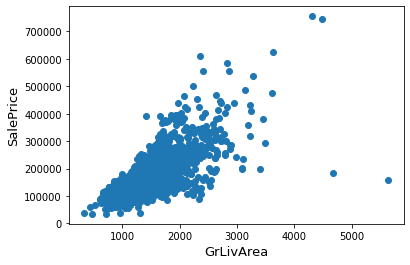

In [ ]:
#Outlier detection skipped
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

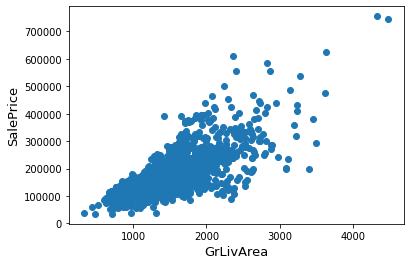

In [ ]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 180932.92 , sigma = 79467.79



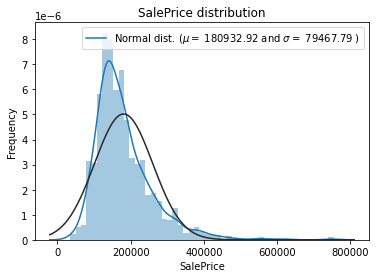

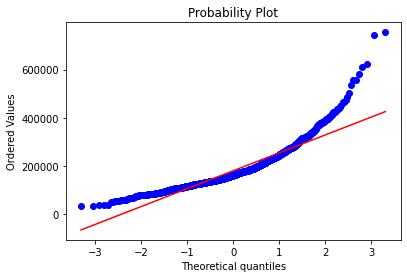

In [ ]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} , sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.02 and sigma = 0.40



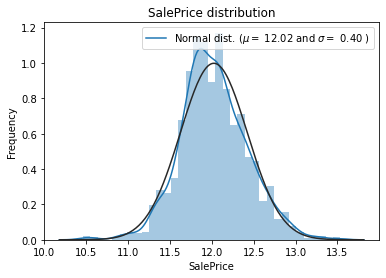

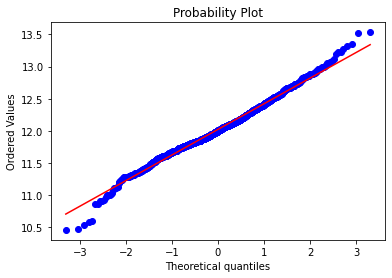

In [ ]:
#log transformation of output variable
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [ ]:
#Concatenate test and train in the same dataset

ntrain = train.shape[0] 
ntest = test.shape[0]

y_train = train.SalePrice.values
df_full = pd.concat((train, test)).reset_index(drop=True)
df_full.drop(['SalePrice'], axis=1, inplace=True)
print("Full data size is : {}".format(df_full.shape))

Full data size is : (2917, 79)


In [ ]:
#Percentage of missing values
df_full_na = (df_full.isnull().mean()) * 100
df_full_na = df_full_na.drop(df_full_na[df_full_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Percent' :df_full_na})
missing_data.head(20)



,Missing Percent
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

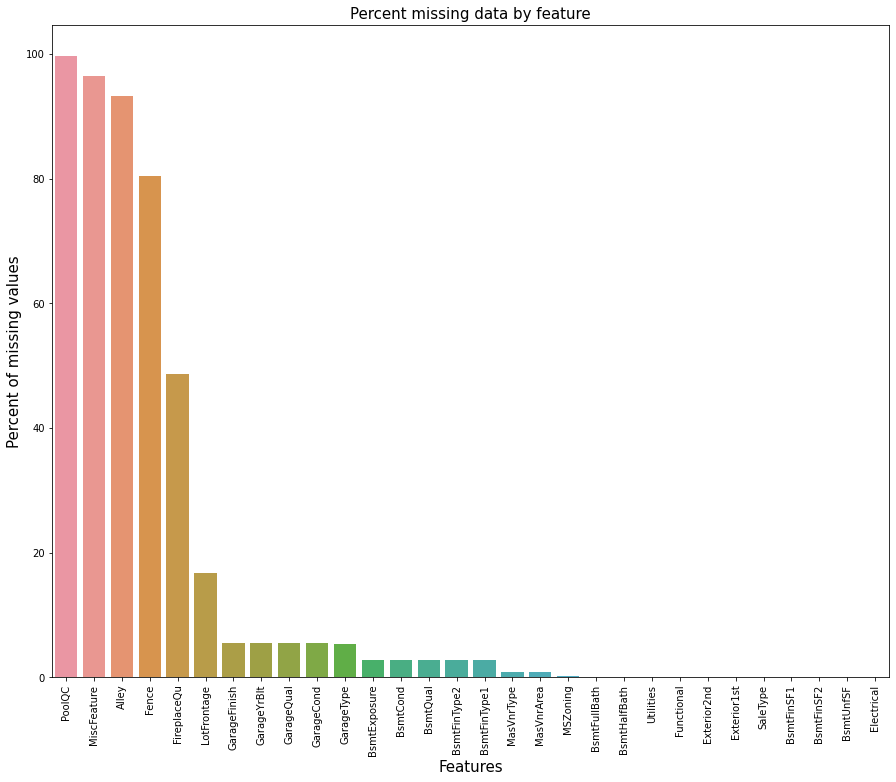

In [ ]:

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=df_full_na.index, y=df_full_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

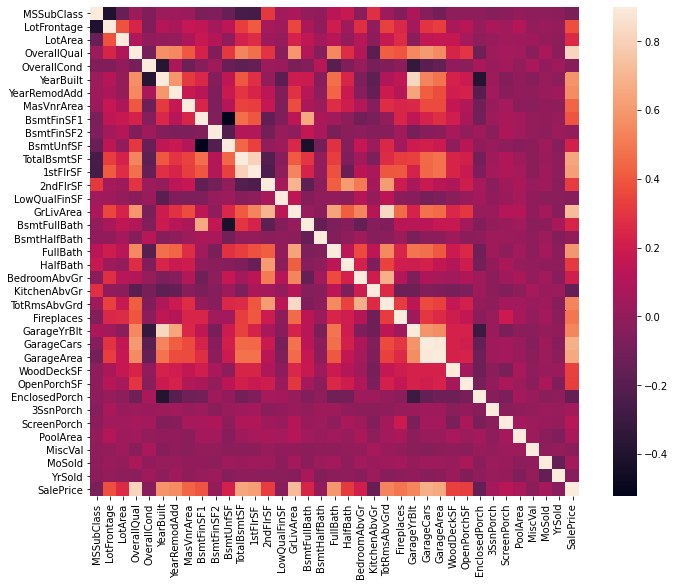

In [ ]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [ ]:
#imputing missing values
df_full['PoolQC'].value_counts()
df_full['PoolQC'] = df_full['PoolQC'].fillna("None")

In [ ]:
df_full['MiscFeature'].value_counts()
df_full['MiscFeature'] = df_full['MiscFeature'].fillna("None")

In [ ]:
df_full['Alley'].value_counts()
df_full['Alley'] = df_full['Alley'].fillna("None")

In [ ]:
df_full['Fence'].value_counts()
df_full['Fence'] = df_full['Fence'].fillna("None")

In [ ]:
df_full['FireplaceQu'].value_counts()
df_full['FireplaceQu'] = df_full['FireplaceQu'].fillna("None")

In [ ]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
df_full["LotFrontage"] = df_full.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [ ]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_full[col] = df_full[col].fillna('None')

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_full[col] = df_full[col].fillna(0)

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_full[col] = df_full[col].fillna(0)

In [ ]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
   df_full[col] = df_full[col].fillna('None')

In [ ]:
df_full["MasVnrType"] = df_full["MasVnrType"].fillna("None")
df_full["MasVnrArea"] = df_full["MasVnrArea"].fillna(0)

In [ ]:
df_full['MSZoning'] = df_full['MSZoning'].fillna(df_full['MSZoning'].mode()[0])

In [ ]:
df_full['Electrical'] = df_full['Electrical'].fillna(df_full['Electrical'].mode()[0])

In [ ]:
df_full = df_full.drop(['Utilities'], axis=1)
df_full["Functional"] = df_full["Functional"].fillna("Typical")
df_full['KitchenQual'] = df_full['KitchenQual'].fillna(df_full['KitchenQual'].mode()[0])
df_full['Exterior1st'] = df_full['Exterior1st'].fillna(df_full['Exterior1st'].mode()[0])
df_full['Exterior2nd'] = df_full['Exterior2nd'].fillna(df_full['Exterior2nd'].mode()[0])
df_full['SaleType'] = df_full['SaleType'].fillna(df_full['SaleType'].mode()[0])



In [ ]:
#Percentage of missing values
df_full_na = (df_full.isnull().mean()) * 100
df_full_na = df_full_na.drop(df_full_na[df_full_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Percent' :df_full_na})
missing_data.head(20)

,Missing Percent


In [ ]:
#Converting some numeric variables which are actually categorical variables 

#MSSubClass=The building class
df_full['MSSubClass'] = df_full['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
df_full['OverallCond'] = df_full['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
df_full['YrSold'] = df_full['YrSold'].astype(str)
df_full['MoSold'] = df_full['MoSold'].astype(str)

In [ ]:
#Label Encoding some of the categorical variables 

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

In [ ]:
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_full[c].values)) 
    df_full[c] = lbl.transform(list(df_full[c].values))

In [ ]:
df_full.shape

(2917, 78)

In [ ]:
#Adding an important feature 

#df_full['TotalSF'] = df_full['TotalBsmtSF'] + df_full['1stFlrSF'] + df_full['2ndFlrSF']

In [ ]:

# Checking for skewness 
numeric_feats = df_full.dtypes[df_full.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_full[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)




Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [ ]:

#leaving this out for now
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lamda = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_full[feat] = boxcox1p(df_full[feat], lamda)

There are 58 skewed numerical features to Box Cox transform


In [ ]:
df_full = pd.get_dummies(df_full)
print(df_full.shape)

(2917, 219)


In [ ]:
train = df_full[:ntrain]
test = df_full[ntrain:]

**Part 2 : Modelling**

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
train.values

array([[ 2.88584647,  5.83132789, 19.21218231, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.05564154,  6.22121363, 19.71220478, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.88584647,  5.91494002, 20.34724091, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 3.01134024,  5.85955121, 19.47634523, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.05564154,  5.91494002, 19.76017576, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.05564154,  6.0986261 , 19.84906344, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
#Going for the best models
model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
score = rmsle_cv(model_GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))



Gradient Boosting score: 0.1177 (0.0081)



In [ ]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1153 (0.0057)



In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
model_xgb.fit(train, y_train)
#xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
#print(rmsle(y_train, xgb_train_pred))

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = xgb_pred
sub.to_csv('submission.csv',index=False)

**Feature Importance**

In [ ]:
from xgboost import XGBClassifier, plot_importance

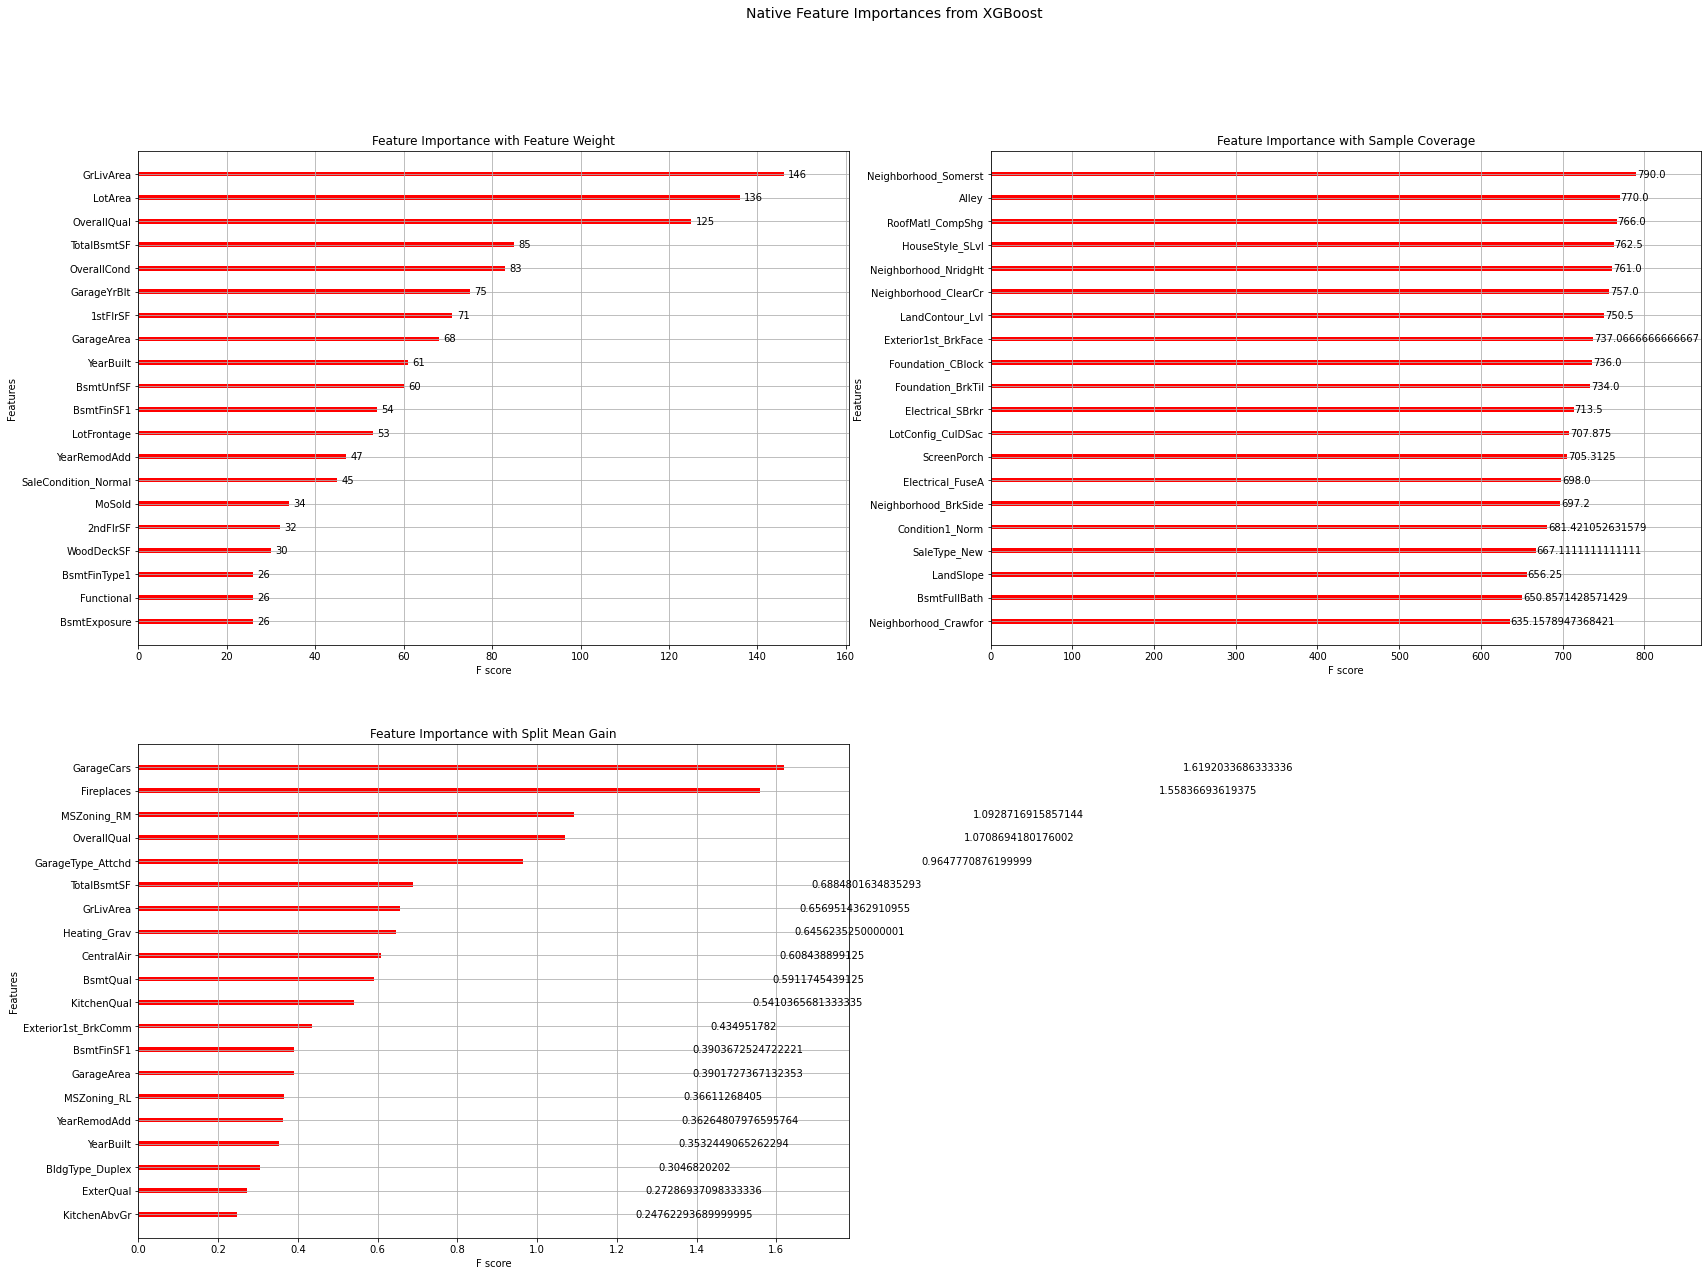

In [ ]:
#@title
# ploting XGBoost default feature importances
fig = plt.figure(figsize = (28, 20))
title = fig.suptitle("Native Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(model_xgb, importance_type='weight', ax=ax1, color='red', max_num_features=20)
ax1.set_title("Feature Importance with Feature Weight");

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(model_xgb, importance_type='cover', ax=ax2, color='red', max_num_features=20)
ax2.set_title("Feature Importance with Sample Coverage");

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(model_xgb, importance_type='gain', ax=ax3, color='red', max_num_features=20)
ax3.set_title("Feature Importance with Split Mean Gain");

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 5.2MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
eli5.show_weights(model_xgb.get_booster())

Weight,Feature
0.0757,GarageCars
0.0729,Fireplaces
0.0511,MSZoning_RM
0.0501,OverallQual
0.0451,GarageType_Attchd
0.0322,TotalBsmtSF
0.0307,GrLivArea
0.0302,Heating_Grav
0.0285,CentralAir
0.0276,BsmtQual


In [ ]:
model_xgb_arrays = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [ ]:
model_xgb_arrays.fit(train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1.7817, missing=None,
             n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
             scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
             verbosity=1)

In [ ]:
features_list = list(train.columns.values)

In [ ]:
feat_permut = PermutationImportance(model_xgb_arrays, random_state=33).fit(train, y_train)
eli5.show_weights(feat_permut, feature_names=features_list)

Weight,Feature
0.1447 ± 0.0060,GrLivArea
0.1084 ± 0.0071,OverallQual
0.0339 ± 0.0020,TotalBsmtSF
0.0207 ± 0.0020,YearBuilt
0.0184 ± 0.0029,OverallCond
0.0162 ± 0.0018,LotArea
0.0110 ± 0.0022,BsmtFinSF1
0.0095 ± 0.0018,GarageArea
0.0075 ± 0.0014,Fireplaces
0.0071 ± 0.0012,YearRemodAdd


In [ ]:
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

     |████████████████████████████████| 57.7MB 74kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp37-none-any.whl size=57690722 sha256=ba54441cbf52a34d586c817e3ce4aa6f07f91c2514b05b36a2e571364a5ff093
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [ ]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


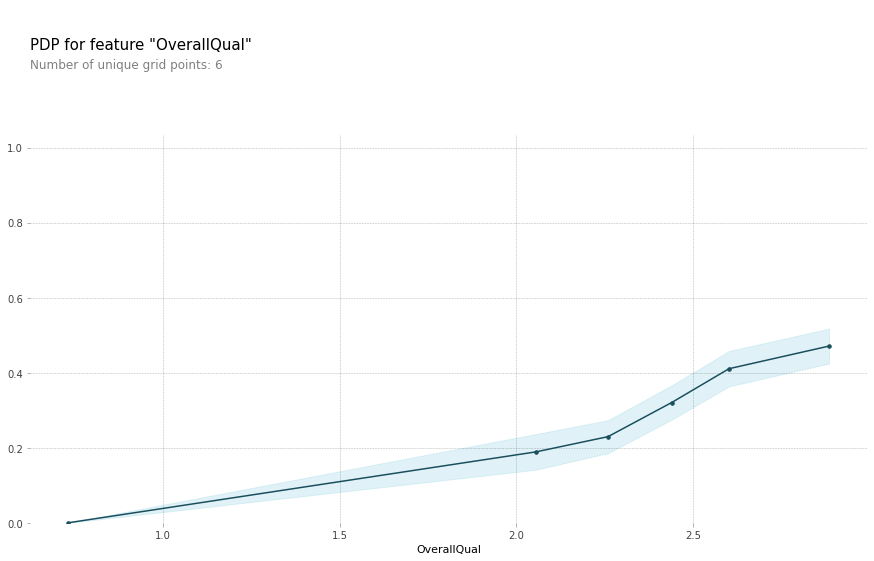

In [ ]:
#@title
# plot the PD univariate plot
plot_pdp(model_xgb, train, 'OverallQual')

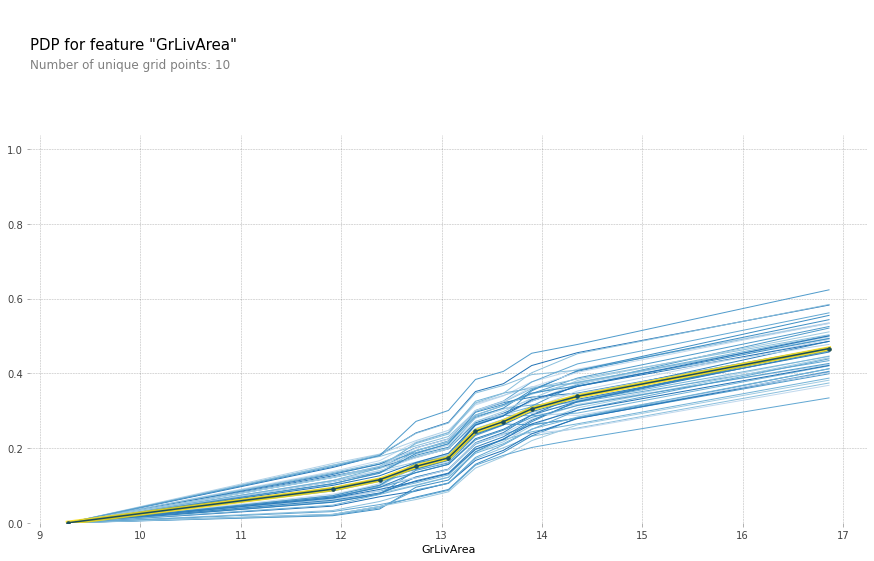

In [ ]:
plot_pdp(model_xgb, train, 'GrLivArea', cluster_flag=True, nb_clusters=50, lines_flag=True)

In [ ]:
#@title
!pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

     |████████████████████████████████| 358kB 11.9MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=0a742f7ee2c2938a5905445b47782ac2b94928fa1701c42170abf7145b295947
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(test)

In [ ]:
#@title
print('Expected Value: ', explainer.expected_value)

Expected Value:  12.027688


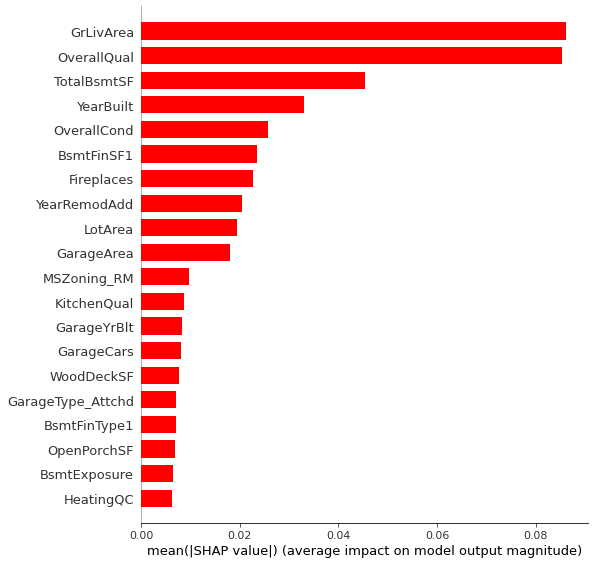

In [ ]:
#@title
shap.summary_plot(shap_values, test, plot_type="bar", color='red')

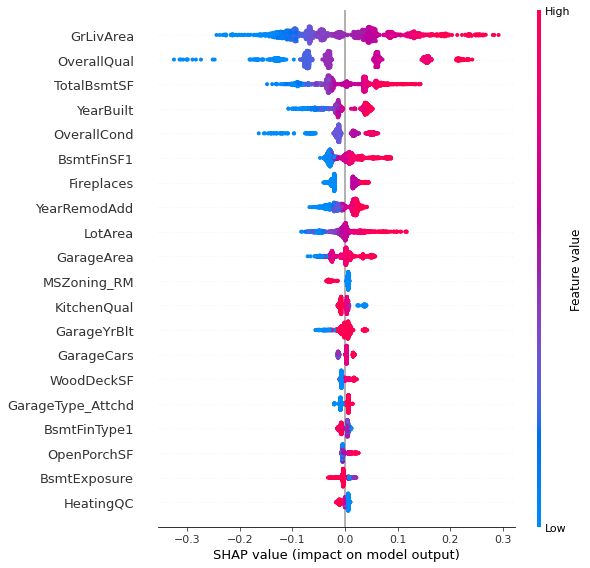

In [ ]:
#@title
shap.summary_plot(shap_values, test)